In [107]:
# %load_ext autoreload
# %autoreload 1
import warnings
warnings.filterwarnings('ignore')
import sys
# sys.path.insert(0, '../SkinCancerClassifier/py')
import pandas as pd
import numpy as np
from numpy.random import seed
seed(111)
import os
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread, imshow
%matplotlib inline
import seaborn as sns
from PIL import Image

import keras
from keras import models
from keras import layers
from keras.models import Model, Sequential, load_model
from keras.layers import Activation, Reshape
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers.convolutional import *
from keras.layers import BatchNormalization, Dropout, AveragePooling2D, GlobalAvgPool2D, MaxPooling2D, Dense, Flatten
from keras.applications import inception_v3, DenseNet121
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint
from keras.regularizers import l2


from tensorflow import set_random_seed
set_random_seed(1112)


In [108]:
def img_name(dir_name):
    img_list = []
    for i in range(0, 7):
        sub_dir= dir_name + str(i) +'/'
        for sub in os.listdir(sub_dir):
            img_list.append(sub)
    return img_list
        

In [109]:
def create_img_dict():

    data_dir = '../SkinCancerClassifier/'
    
    # Create dataframe of raw data
    raw_metadata_df = pd.read_csv(data_dir + 'HAM10000_metadata.csv')
    
    # Directories for images in train, validation, and test
    image_test_dir = '../SkinCancerClassifier/test_dir/'
    image_train_dir = '../SkinCancerClassifier/train_dir/'
    image_val_dir = '../SkinCancerClassifier/valid_dir/'
    
    # Create a combined list images in all directories with their full file/image path
    img_test_list = img_name(image_test_dir)
    img_test_list = [image_test_dir + img_name for img_name in img_test_list]
    img_train_list = img_name(image_train_dir)
    img_train_list = [image_train_dir + img_name for img_name in img_train_list]
    img_val_list = img_name(image_val_dir)
    img_val_list = [image_val_dir + img_name for img_name in img_val_list]
    all_img_list = img_test_list + img_train_list + img_val_list
    
    # Create a dictionnary that has the name of the image as its key and the image path as its value
    image_dict = {os.path.splitext(os.path.basename(img_name))[0]: img_name for img_name in all_img_list}
    
    return raw_metadata_df, image_dict

In [110]:
def set_df():
    # Create dictionary with the diagnostic categories of pigmented lesions
    lesion_cat_dict = {
        
        'akiec': 'Actinic keratoses',
        'bcc': 'Basal cell carcinoma',
        'bkl': 'Benign keratosis',
        'df': 'Dermatofibroma',
        'mel': 'Melanoma',
        'nv': 'Melanocytic nevi',
        'vasc': 'Vascular lesions'
    }

    # Get raw dataframe and the image dictionnary
    df, img_dict = create_img_dict()


    # Create new column file_path and use the image_id as the key of image_dict and map 
    # its corresponding value to get the path for the image
    df['file_path'] = df['image_id'].map(img_dict.get)

    # Create new column category_name and use dx as the key to lesion_cat_dict and map 
    # it to its corresponding value to get the lesion name
    df['category_name'] = df['dx'].map(lesion_cat_dict.get)

    # Create new column category_id and assign the integer codes 
    # of the category_name that were transformed into pandas categorical datatype
    df['category_id'] = pd.Categorical(df['category_name']).codes

    # Fill age null values by the mean age
    df.age.fillna(df.age.mean(), inplace=True)
    
    return df

In [111]:
image_test_dir = '../SkinCancerClassifier/test_dir/'
image_train_dir = '../SkinCancerClassifier/train_dir/'
image_val_dir = '../SkinCancerClassifier/valid_dir/'

In [112]:
def split_images(train_dir=image_train_dir, test_dir=image_test_dir, val_dir=image_val_dir, target_size=(90, 120)):
  
    # Directories for images in train, validation, and test
    train_destination = train_dir
    test_destination = test_dir
    valid_destination = val_dir

    # Rescale test, train, and validation images. Resize them to 90 x 120 pixels
    test_data = ImageDataGenerator(rescale=1./255).flow_from_directory(test_destination, 
                                                                        target_size=target_size,
                                                                        batch_size = 2000, 
                                                                        seed = 1212) 
    
    # Apply various transformations to the training data
    # to help the model generalize better on the test data
    train_data = ImageDataGenerator(rotation_range=10,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    shear_range=0.1,
                                    zoom_range=0.1,
                                    horizontal_flip=True,
                                    rescale=1./255).flow_from_directory(train_destination, 
                                                                        target_size=target_size, 
                                                                        batch_size = 147, 
                                                                        seed = 1212) 

    valid_data = ImageDataGenerator(rescale=1./255).flow_from_directory( 
            valid_destination, 
            target_size=target_size,
            batch_size = 300,
            seed = 1212) 


    return test_data, train_data, valid_data

In [113]:
def set_cnn_model(input_shape=(90, 120, 3)):
    '''A very simple CNN model with one convolution layer
        and one dense layer just to get a baseline'''
    cnn = models.Sequential()
    cnn.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', dilation_rate=(2, 2), kernel_regularizer=l2(0.02), input_shape=input_shape))
    cnn.add(BatchNormalization())
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Flatten())
    cnn.add(Dense(32, activation='relu'))
    cnn.add(Dropout(0.3))
    cnn.add(BatchNormalization())
    cnn.add(Dense(7, activation='softmax'))

    print(cnn.summary())
    
    return cnn

In [114]:
def fit_cnn_model(cnn, epoch=20, batch_num=32, reduce_by=0.5):
    '''Fit the simple CNN model'''
   
    # images_train, labels_train, images_test, labels_test, images_val, labels_val = split_images()
    test_data, train_data, valid_data = split_images()
    optimize = SGD(lr=1e-1, momentum=0.9) 
    
    cnn.compile(loss='categorical_crossentropy',
                optimizer=optimize,
                metrics=['accuracy'])
    
    rlrop = ReduceLROnPlateau(
                                monitor='val_loss', 
                                patience=4, 
                                verbose=1, 
                                factor=0.0001, 
                                min_lr=0.000001
                            )
    checkpoint = ModelCheckpoint(filepath='../SkinCancerClassifier/saved_models/First_CNN_11.h5', verbose=1)
    
    cnn.fit_generator(train_data,
                       steps_per_epoch= 200 * reduce_by,
                       # np.ceil(train_data.samples/train_data.batch_size),
                       epochs=epoch, 
                       verbose=1,
                       callbacks=[checkpoint, rlrop], 
                       validation_data=valid_data, 
                       validation_steps=32, 
                       workers=8, 
                       use_multiprocessing=True 
                       )
    return test_data



In [115]:

def set_cnn_bn_l2_model():
    cnn = models.Sequential()
    cnn.add(Conv2D(128, (1, 1), activation='relu', kernel_initializer='he_uniform', 
            dilation_rate=(2, 2), kernel_regularizer=l2(0.02),input_shape=input_shape))
    cnn.add(BatchNormalization())
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.02)))
    cnn.add(BatchNormalization())
    cnn.add(MaxPooling2D((2, 2))) 
    cnn.add(Flatten())
    cnn.add(layers.Dense(32, activation='relu', kernel_regularizer=l2(0.02)))
    cnn.add(Dropout(0.5))
    cnn.add(BatchNormalization())
    cnn.add(Dense(7, activation='softmax'))

    print(cnn.summary())
    
    return cnn

In [116]:
def fit_cnn_bn_l2_model(cnn, batch_num=32, loss_param='categorical_crossentropy', epoch=40, reduce_by=0.5):
  
    callbacks_list = []
    test_data, train_data, valid_data = split_images()
   
    rlrop = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=5) 
    
    
    sgd = SGD(lr=0.1, momentum=0.95, nesterov=False)
    
    cnn.compile(loss=loss_param,
                optimizer=sgd,
                metrics=['accuracy'])
    
#     lrate = LearningRateScheduler(step_decay)
#     callbacks_list = [lrate]
    checkpointer = ModelCheckpoint(filepath='../SkinCancerClassifier/saved_models/cnn_bnn_balanced_2.h5', verbose=1)
    cnn.fit_generator(train_data,
                       steps_per_epoch= 200 * reduce_by,
#                       np.ceil(train_data.samples/train_data.batch_size),
                       epochs=epoch, 
                       verbose=1,
                       callbacks=[checkpointer], 
                       validation_data=valid_data, 
                       validation_steps=np.ceil(valid_data.samples/valid_data.batch_size), 
                       workers=16, 
                       use_multiprocessing=True, 
                       shuffle=True)

    


In [117]:
# test_img=te_labels.argmax(axis=1)

def plot_confusion_matrix(te_label, y_pred):
    # Calculate Confusion Matrix
    cm = confusion_matrix(te_label, y_pred)
    df = set_df()
    # Figure adjustment and heatmap plot
    f = plt.figure(figsize=(10,10))
    ax= plt.subplot()
    labels = df.groupby('category_id').category_name.first().values
    sns.heatmap(cm, annot=True, ax = ax, vmax=100, cbar=False, cmap='Paired', mask=(cm==0), fmt=',.0f', linewidths=2, linecolor='grey', ); 

    # labels
    ax.set_xlabel('Predicted labels', fontsize=16);
    ax.set_ylabel('True labels', labelpad=30, fontsize=16); 
    ax.set_title('Confusion Matrix', fontsize=18); 
    ax.xaxis.set_ticklabels(labels, rotation=90); 
    ax.yaxis.set_ticklabels(labels, rotation=0);
    ax.set_facecolor('white')
    
    report = classification_report(te_label, y_pred, target_names=df.groupby('category_id').category_name.first().values)
    print(report)

In [118]:

# learning rate schedule
def step_decay(epoch=5):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [119]:
def dense_model(num_classes=7, inp_shape=(90, 120, 3), reduce_by=0.5):
    
    base_model = DenseNet121(weights=None, include_top=False, input_shape=inp_shape)
    x = AveragePooling2D(pool_size=(2,2), name='avg_pool')(base_model.output) 
    BatchNormalization()
    x = Flatten()(x)
    x = Dense(1024, activation='relu', name='dense_post_pool')(x)
    BatchNormalization()
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax', name='predictions')(x)
    model = Model(inputs=base_model.input, output=output)
    
    
    # let's visualize layer names and layer indices to see how many layers we should freeze:
    for i, layer in enumerate(model.layers):
        print(i, layer.name)
    
    for layer in model.layers[:427]:
        layer.trainable = False
    
    for layer in model.layers[427:]:
        layer.trainable = True
    
    rlrop = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=10) 
    sgd = SGD(lr=0.1, momentum=0.9, nesterov=False)
    
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

    test_data, train_data, valid_data = split_images()
    
    model.fit_generator(generator=train_data,
                    validation_data=valid_data,
                    validation_steps = 32,
                    steps_per_epoch = 200 * reduce_by,
                    callbacks=[rlrop],
                    epochs=epoch)
    
    model.save('../SkinCancerClassifier/saved_models/densenet121_101.h5')
    
    return test_data, model



In [120]:
def imagenet_classifier(inp_shape=(90, 120, 3)):
    imagenet=inception_v3.InceptionV3(weights='imagenet',include_top=False, input_shape=inp_shape)
    imagenet_new =imagenet.output
    new_imagenet = models.Sequential()
    new_imagenet.add(imagenet)
    new_imagenet.add(GlobalAvgPool2D())
    new_imagenet.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.02)))
    new_imagenet.add(BatchNormalization())
    new_imagenet.add(Dense(512, activation='relu', kernel_regularizer=l2(0.02)))
    new_imagenet.add(BatchNormalization())
    new_imagenet.add(Dense(128, activation='relu', kernel_regularizer=l2(0.02)))
    new_imagenet.add(BatchNormalization())
    new_imagenet.add(Dense(7,activation='softmax')) #final layer with softmax activation
    
    return new_imagenet
 

In [121]:
def train_imagenet_classifier(new_imagenet, epoch=30, reduce_by=0.5):   
        
    # Print all layers in imagenet
    for i, layer in enumerate(new_imagenet.layers):
        print(i, layer.name)
    
    # Freeze layer - no training
    for layer in new_imagenet.layers[:1]:
        layer.trainable=False
    
    rlrop = ReduceLROnPlateau(
                                monitor='val_loss', 
                                patience=4, 
                                verbose=1, 
                                factor=1e-4, 
                                min_lr=1e-6
                            )
    
   # Use Stochastic Gradient Descent with set learnig rate and momentum
    sgd = SGD(lr=0.1, momentum=0.9)
    
    checkpoint = ModelCheckpoint(filepath='../SkinCancerClassifier/saved_models/imagenet_1157.h5', 
                                   verbose=1)
    
    new_imagenet.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    print(new_imagenet.summary())
    
    test_data, train_data, valid_data = split_images()
    
    new_imagenet.fit_generator(generator=train_data,
                    validation_data=valid_data,
                    validation_steps = 32,
                    steps_per_epoch = 200 * reduce_by, 
                    callbacks=[rlrop, checkpoint],
                    epochs=epoch)
    

    return test_data, new_imagenet

In [122]:
def set_cnn_no_dense_model(input_shape = (90, 120, 3), num_classes = 7):
    ''' Created a model with only convolutional layers and no dense layers'''

    model = Sequential()

    model.add(Conv2D(32,kernel_size=(3, 3),activation='relu',name="Conv1", input_shape=input_shape)) 
    model.add(BatchNormalization(name="Norm1"))
    model.add(Conv2D(64,kernel_size=(3, 3), activation='relu',name="Conv2")) 
    model.add(BatchNormalization(name="Norm2"))
    model.add(Conv2D(64,kernel_size=(3, 3), activation='relu',name="Conv3")) 
    model.add(BatchNormalization(name="Norm3"))
    model.add(MaxPooling2D(pool_size = (2, 2))) 
    model.add(Dropout(0.20))

    model.add(Conv2D(64, (3, 3), activation='relu',name="Conv4")) 
    model.add(BatchNormalization(name="Norm4"))
    model.add(Conv2D(128, (3, 3), activation='relu',name="Conv5")) 
    model.add(BatchNormalization(name="Norm5"))
    model.add(Conv2D(128, (3, 3), activation='relu',name="Conv6")) 
    model.add(BatchNormalization(name="Norm6"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.20))

    model.add(Conv2D(128, (3, 3), activation='relu',name="Conv7")) 
    model.add(BatchNormalization(name="Norm7"))
    model.add(Conv2D(256, (3, 3), activation='relu',name="Conv8")) 
    model.add(BatchNormalization(name="Norm8"))
    model.add(Conv2D(256, (3, 3), activation='relu',name="Conv9")) 
    model.add(BatchNormalization(name="Norm9"))
    model.add(MaxPooling2D(pool_size=(2, 2))) #6,9
    model.add(Dropout(0.20))

    model.add(Conv2D(7,(1,1),name="conv10",activation="relu")) 
    model.add(BatchNormalization(name="Norm10"))
    model.add(Conv2D(7,kernel_size=(6,9),name="Conv11"))
    model.add(Flatten())
    model.add(Activation('softmax'))
    
    return model

In [123]:
def fit_cnn_no_dense_model(model, start_at_epoch,  epoch, reduce_by=0.5):   
    # Compile the model
    model.compile(optimizer = 'adam', loss = "categorical_crossentropy", metrics=["accuracy"])
    
    # Set learning rate plateau 
    rlrop = ReduceLROnPlateau(monitor='val_loss', 
                                patience=4, 
                                verbose=1, 
                                factor=1e-4, 
                                min_lr=1e-6)
    
    checkpoint = ModelCheckpoint(filepath='../SkinCancerClassifier/saved_models/cnn_nodense_model3.h5', 
                                   verbose=1)
    
    test_data, train_data, valid_data = split_images()
    
    model.fit_generator(generator=train_data,
                        validation_data=valid_data,
                        validation_steps = 32,
                        steps_per_epoch = 200 * reduce_by,
                        callbacks=[rlrop, checkpoint],
                        initial_epoch=start_at_epoch,
                        epochs=epoch)
    
    return test_data, model

### End Functions

# Exploratory Data Analysis

In [124]:
# Get dataframe, perform data cleaning, and new columns of relevant data
df = set_df()

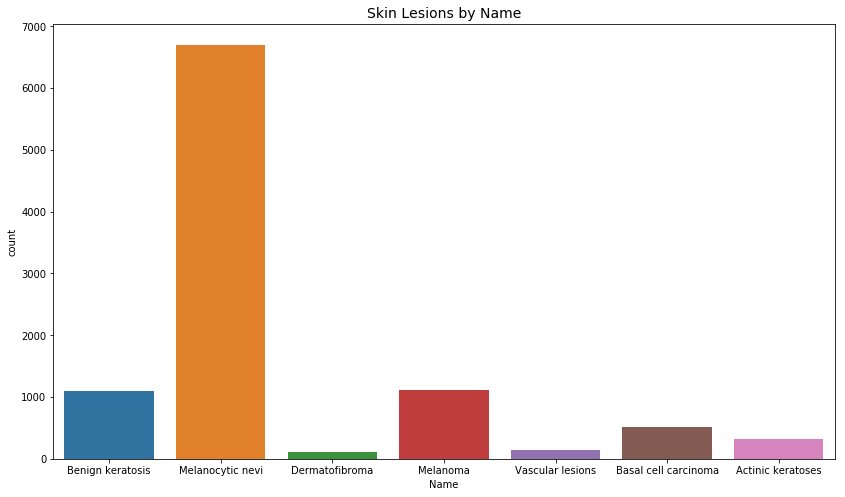

In [135]:
# The overwhelming majority of skin cancer is Melanocytic Nevi, followed by Melanoma, and Begnin Keratosis
plt.figure(figsize=(14,8))
plt.title("Skin Lesions by Name", fontsize=14)
sns.countplot(df.category_name)
plt.xlabel('Name');

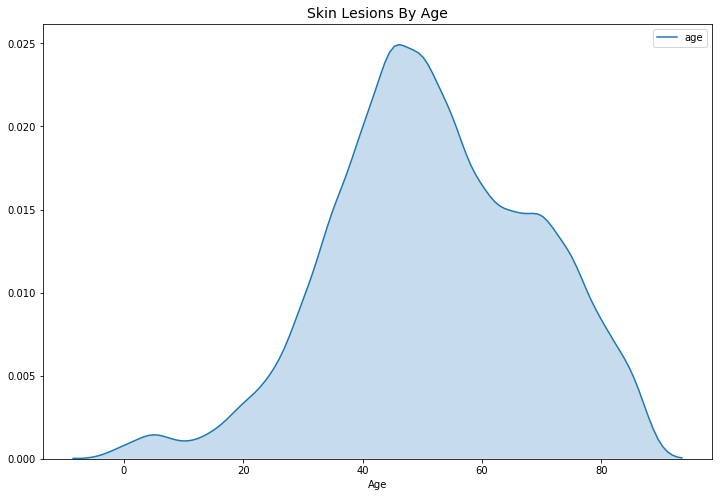

In [147]:
plt.figure(figsize=(12,8))
plt.title("Skin Lesions By Age", fontsize=14)
sns.kdeplot(df['age'],shade=True)
plt.xlabel('Age');

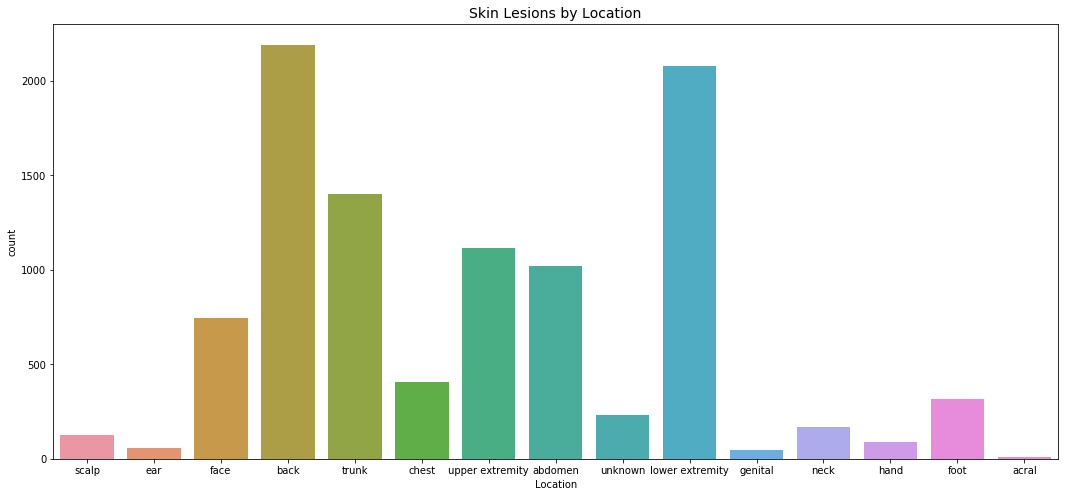

In [211]:
# It seems that the back and local extremity is where we find these bad actors
plt.figure(figsize=(18,8))
plt.title("Skin Lesions by Location", fontsize=14)
sns.countplot(df.localization)
plt.xlabel('Location');

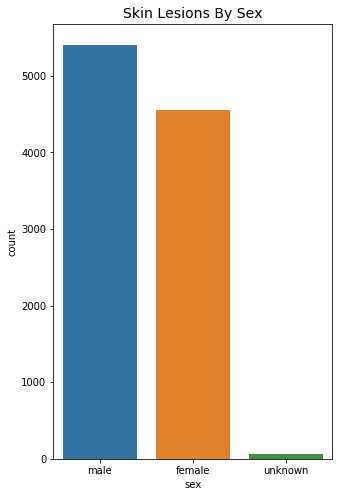

In [214]:
# Skin Lesion Count by Sex
plt.figure(figsize=(5,8))
plt.title("Skin Lesions By Sex", fontsize=14)
sns.countplot(df.sex);

In [26]:
image_val_dir = '../SkinCancerClassifier/valid_dir/'

In [205]:
actinic_keratosis_0 = ['../SkinCancerClassifier/valid_dir/0/ISIC_0026848.jpg', 
                       '../SkinCancerClassifier/valid_dir/0/ISIC_0026729.jpg', 
                       '../SkinCancerClassifier/valid_dir/0/ISIC_0030280.jpg', 
                       '../SkinCancerClassifier/valid_dir/0/ISIC_0024329.jpg']

basal_carcinoma_1 = ['../SkinCancerClassifier/valid_dir/1/ISIC_0024666.jpg',
                     '../SkinCancerClassifier/valid_dir/1/ISIC_0025417.jpg',
                     '../SkinCancerClassifier/valid_dir/1/ISIC_0025046.jpg',
                     '../SkinCancerClassifier/valid_dir/1/ISIC_0026395.jpg']


benign_keratosis_2 = ['../SkinCancerClassifier/valid_dir/2/ISIC_0024312.jpg',
                      '../SkinCancerClassifier/valid_dir/2/ISIC_0024477.jpg',
                      '../SkinCancerClassifier/valid_dir/2/ISIC_0024786.jpg',
                      '../SkinCancerClassifier/valid_dir/2/ISIC_0025157.jpg']


dermatofibroma_3 = ['../SkinCancerClassifier/valid_dir/3/ISIC_0024386.jpg',
                    '../SkinCancerClassifier/valid_dir/3/ISIC_0027648.jpg',
                    '../SkinCancerClassifier/valid_dir/3/ISIC_0029891.jpg',
                    '../SkinCancerClassifier/valid_dir/3/ISIC_0030830.jpg']


melanocytic_nv_4 = ['../SkinCancerClassifier/valid_dir/4/ISIC_0024340.jpg',
                    '../SkinCancerClassifier/valid_dir/4/ISIC_0025011.jpg',
                    '../SkinCancerClassifier/valid_dir/4/ISIC_0026010.jpg',
                    '../SkinCancerClassifier/valid_dir/4/ISIC_0027040.jpg']
    

melanoma_5 = ['../SkinCancerClassifier/valid_dir/5/ISIC_0024459.jpg',
              '../SkinCancerClassifier/valid_dir/5/ISIC_0026131.jpg',
              '../SkinCancerClassifier/valid_dir/5/ISIC_0027100.jpg',
              '../SkinCancerClassifier/valid_dir/5/ISIC_0034275.jpg']


vascular_lesions_6 = ['../SkinCancerClassifier/valid_dir/6/ISIC_0024904.jpg',
                      '../SkinCancerClassifier/valid_dir/6/ISIC_0031706.jpg',
                      '../SkinCancerClassifier/valid_dir/6/ISIC_0033123.jpg',
                      '../SkinCancerClassifier/valid_dir/6/ISIC_0033608.jpg']


In [206]:
'.../SkinCancerClassifier/valid_dir/1/ISIC_0024360.jpg'
'.../SkinCancerClassifier/valid_dir/1/ISIC_0024403.jpg'
'.../SkinCancerClassifier/valid_dir/1/ISIC_0024443.jpg'
'.../SkinCancerClassifier/valid_dir/1/ISIC_0024454.jpg'
'.../SkinCancerClassifier/valid_dir/1/ISIC_0025417.jpg'
# ISIC_0025417.jpg

'.../SkinCancerClassifier/valid_dir/1/ISIC_0025417.jpg'

In [207]:
def plot_skin_images(img_list, title):
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(12 ,2))
    fig.suptitle(title)
    ax1.imshow(imread(img_list[0]))
    ax2.imshow(imread(img_list[1]))
    ax3.imshow(imread(img_list[2]))
    ax4.imshow(imread(img_list[3]))
#     ax5.imshow(imread(img_list[4]))
    ax1.set_axis_off()
    ax2.set_axis_off()
    ax3.set_axis_off()
    ax4.set_axis_off()
#     ax5.set_axis_off();

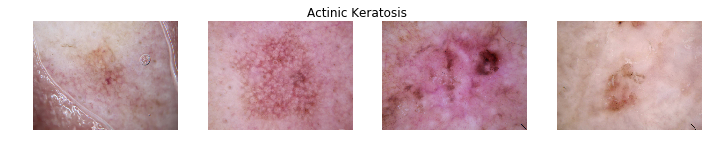

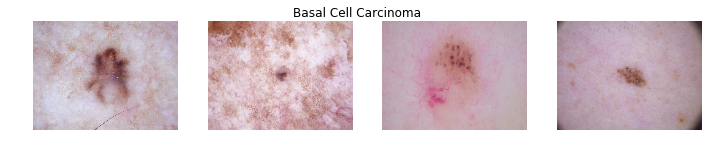

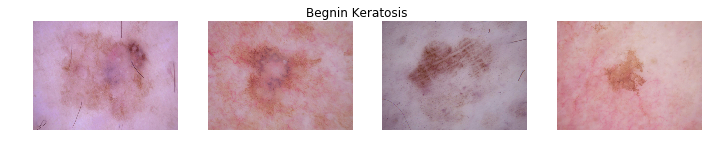

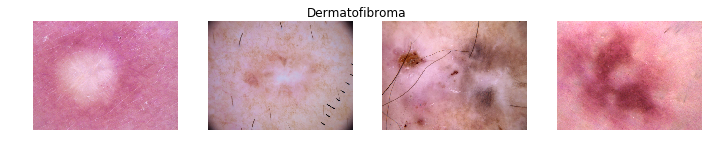

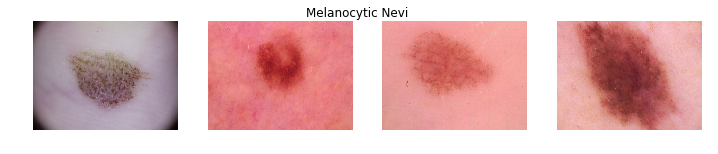

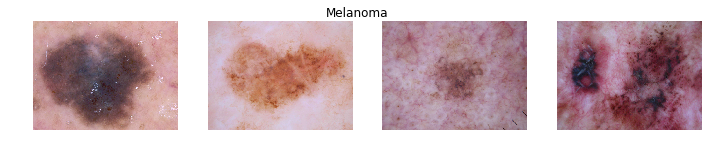

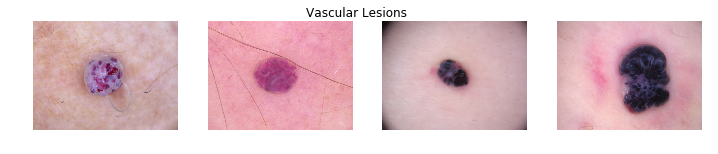

In [209]:
# Displaying 4 images per category of skin lesions
plot_skin_images(actinic_keratosis_0, 'Actinic Keratosis'); plot_skin_images(basal_carcinoma_1, 'Basal Cell Carcinoma'); plot_skin_images(benign_keratosis_2, 'Begnin Keratosis'); plot_skin_images(dermatofibroma_3, 'Dermatofibroma'); plot_skin_images(melanocytic_nv_4, 'Melanocytic Nevi');plot_skin_images(melanoma_5, 'Melanoma'); plot_skin_images(vascular_lesions_6, 'Vascular Lesions')



In [ ]:
test_data, imagenest_clf = imagenet_classifier() 
#  rlrop = ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.00001, min_lr=0.000001) 

0 inception_v3
1 global_average_pooling2d_3
2 dense_9
3 batch_normalization_736
4 dense_10
5 batch_normalization_737
6 dense_11
7 batch_normalization_738
8 dense_12
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 1, 2, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_736 (Bat (None, 1024)              4096      
_________________________________________________________________
dense_10 (Dense)             (None, 512)               524800    
_________________________________________________________________
batch_normalization_737 (Bat (None, 512)   

KeyboardInterrupt: 

In [30]:
test_data, cnn_clf =  cnn_no_dense_model() 
#   rlrop = ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.1, min_lr=0.000001)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Found 2000 images belonging to 7 classes.
Found 30050 images belonging to 7 classes.
Found 1600 images belonging to 7 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
200/200 [==============================] - 314s 2s/step - loss: 1.2685 - acc: 0.5131 - val_loss: 2.1023 - val_acc: 0.4757

Epoch 00001: saving model to ../SkinCancerClassifier/saved_models/cnn_nodense_model.h5
Epoch 2/20
200/200 [==============================] - 298s 1s/step - loss: 0.9238 - acc: 0.6493 - val_loss: 1.4115 - val_acc: 0.5403

Epoch 00002: saving model to ../SkinCancerClassifier/saved_models/cnn_nodense_model.h5
Epoch 3/20
200/200 [==============================] - 296s 1s/step - loss: 0.7756 - acc: 0.7053 - val_loss: 1.5873 - val_acc: 0.4974

Epoch 00003: saving model to ../SkinCancerClassifier/saved_models/cnn_nodense_model.h5
Epoch 4/20
200/200 [===========================

KeyboardInterrupt: 

In [59]:
test_data, _, _ = split_images()

Found 2000 images belonging to 7 classes.
Found 30050 images belonging to 7 classes.
Found 1600 images belonging to 7 classes.


In [60]:
te_img, te_label = next(test_data)

In [77]:
model = load_model('../SkinCancerClassifier/saved_models/cnn_nodense_model.h5')

In [62]:
model.evaluate(te_img, te_label)
y_pred = model.predict(te_img)

2000/2000 [==============================] - 25s 12ms/step


In [63]:
y_pred

array([[1.1637142e-03, 2.0869639e-04, 4.5324415e-02, ..., 9.4673705e-01,
        6.5373802e-03, 1.4853771e-05],
       [5.4681504e-07, 3.0487001e-08, 1.5740872e-03, ..., 8.5715967e-01,
        1.4123908e-01, 9.9547140e-07],
       [1.0308044e-05, 3.7756442e-06, 6.1550033e-03, ..., 1.5872046e-03,
        9.9224150e-01, 8.1446963e-08],
       ...,
       [1.5715485e-05, 4.7422791e-06, 1.2243907e-02, ..., 9.8639143e-01,
        1.1386056e-03, 1.8424393e-05],
       [2.0663731e-06, 1.1178056e-06, 1.6117151e-04, ..., 7.6933879e-01,
        2.2798014e-01, 1.6259662e-06],
       [7.0285029e-07, 3.7703578e-09, 3.5782671e-04, ..., 9.9887842e-01,
        7.4031460e-04, 1.1185632e-05]], dtype=float32)

                                precision    recall  f1-score   support

             Actinic keratoses       0.40      0.32      0.36        65
          Basal cell carcinoma       0.54      0.75      0.62       102
Benign keratosis-like lesions        0.57      0.30      0.39       219
                Dermatofibroma       0.56      0.22      0.31        23
              Melanocytic nevi       0.89      0.85      0.87      1341
                      Melanoma       0.38      0.59      0.46       222
              Vascular lesions       0.60      0.86      0.71        28

                     micro avg       0.73      0.73      0.73      2000
                     macro avg       0.56      0.56      0.53      2000
                  weighted avg       0.75      0.73      0.73      2000



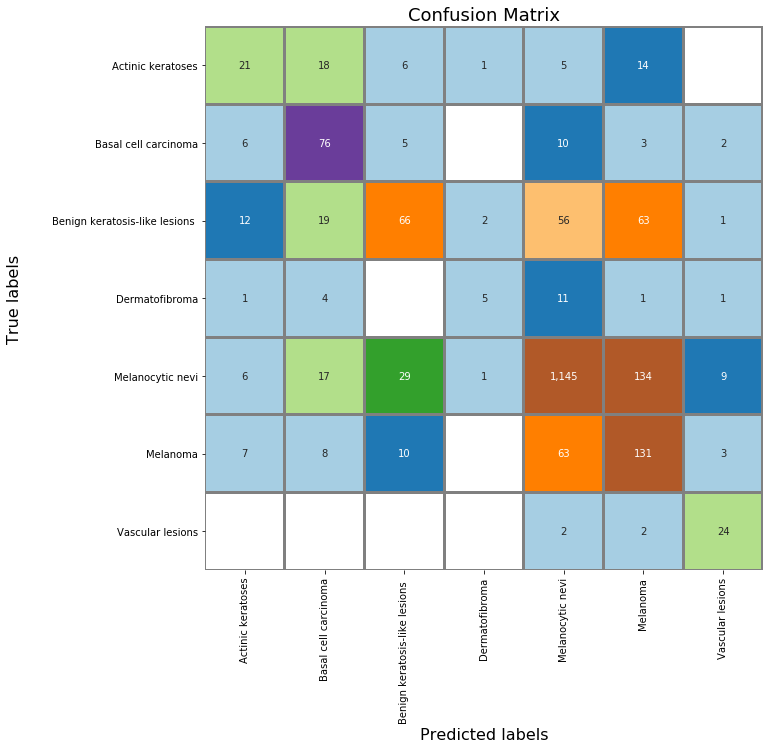

In [51]:
plot_confusion_matrix(te_label.argmax(axis=1), y_pred.argmax(axis=1))

In [ ]:
model = load_model('../SkinCancerClassifier/saved_models/cnn_nodense_model.h5')

In [ ]:
test_data, clf = fit_cnn_no_dense_model(model, 11,  30)

Found 2000 images belonging to 7 classes.
Found 30050 images belonging to 7 classes.
Found 1600 images belonging to 7 classes.
Epoch 12/30
100/100 [==============================] - 240s 2s/step - loss: 0.2714 - acc: 0.8968 - val_loss: 1.3440 - val_acc: 0.6321

Epoch 00012: saving model to ../SkinCancerClassifier/saved_models/cnn_nodense_model2.h5
Epoch 13/30
100/100 [==============================] - 176s 2s/step - loss: 0.2709 - acc: 0.8980 - val_loss: 1.3395 - val_acc: 0.6066

Epoch 00013: saving model to ../SkinCancerClassifier/saved_models/cnn_nodense_model2.h5
Epoch 14/30
100/100 [==============================] - 173s 2s/step - loss: 0.2528 - acc: 0.9050 - val_loss: 1.8162 - val_acc: 0.5620

Epoch 00014: saving model to ../SkinCancerClassifier/saved_models/cnn_nodense_model2.h5
Epoch 15/30
100/100 [==============================] - 173s 2s/step - loss: 0.2421 - acc: 0.9103 - val_loss: 0.9794 - val_acc: 0.7048

Epoch 00015: saving model to ../SkinCancerClassifier/saved_models/cnn

In [83]:
te_img, te_label = next(test_data)

In [85]:
model.evaluate(te_img, te_label)
y_pred = model.predict(te_img)

2000/2000 [==============================] - 4s 2ms/step ETA: 


                                precision    recall  f1-score   support

             Actinic keratoses       0.45      0.38      0.41        65
          Basal cell carcinoma       0.60      0.67      0.63       102
Benign keratosis-like lesions        0.53      0.60      0.57       219
                Dermatofibroma       0.42      0.43      0.43        23
              Melanocytic nevi       0.93      0.83      0.88      1341
                      Melanoma       0.43      0.66      0.52       222
              Vascular lesions       0.81      0.75      0.78        28

                     micro avg       0.76      0.76      0.76      2000
                     macro avg       0.60      0.62      0.60      2000
                  weighted avg       0.79      0.76      0.77      2000



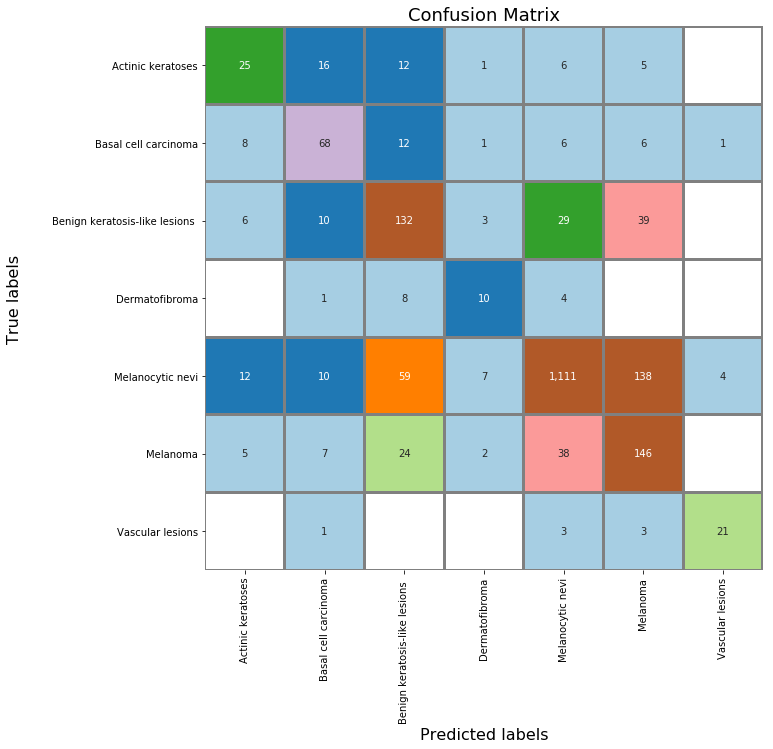

In [86]:
plot_confusion_matrix(te_label.argmax(axis=1), y_pred.argmax(axis=1))

In [44]:
report = classification_report(te_labels.argmax(axis=1), y_pred.argmax(axis=1), target_names=df.groupby('category_id').category_name.first().values)
print(report)

                                precision    recall  f1-score   support

             Actinic keratoses       0.41      0.48      0.44        65
          Basal cell carcinoma       0.55      0.66      0.60       102
Benign keratosis-like lesions        0.48      0.59      0.53       219
                Dermatofibroma       0.67      0.52      0.59        23
              Melanocytic nevi       0.92      0.78      0.85      1341
                      Melanoma       0.40      0.64      0.49       222
              Vascular lesions       0.91      0.75      0.82        28

                     micro avg       0.73      0.73      0.73      2000
                     macro avg       0.62      0.63      0.62      2000
                  weighted avg       0.78      0.73      0.74      2000



In [67]:
## KEEP FULL BALANCED
fit_cnn_model(cnn)

Found 2000 images belonging to 7 classes.
Found 30050 images belonging to 7 classes.
Found 1600 images belonging to 7 classes.


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/20
614/614 [==============================] - 61s 100ms/step - loss: 2.4432 - acc: 0.2404 - val_loss: 2.5243 - val_acc: 0.0833

Epoch 00001: val_loss improved from inf to 2.52427, saving model to ../SkinCancerClassifier/saved_models/CNN_Balanced_1.h5
Epoch 2/20
614/614 [==============================] - 28s 45ms/step - loss: 2.1089 - acc: 0.2122 - val_loss: 1.6549 - val_acc: 0.6200

Epoch 00002: val_loss improved from 2.52427 to 1.65492, saving model to ../SkinCancerClassifier/saved_models/CNN_Balanced_1.h5
Epoch 3/20
614/614 [==============================] - 28s 45ms/step - loss: 4.4351 - acc: 0.1948 - val_loss: 1.9374 - val_acc: 0.1256

Epoch 00003: val_loss did not improve from 1.65492
Epoch 4/20
614/614 [==============================] - 28s 45ms/step - loss: 1.9579 - acc: 0.1926 - val_loss: 1.7676 - val_acc: 0.1367

Epoch 00004: val_loss did not improve from 1.65492
Epoch 5/20
614/614 [==============================] - 29s 48ms/step - loss: 2.2349 - acc: 0.1863 - val_loss

In [ ]:
te_img, te_labels = next(test_data)

In [ ]:
cnn_bnn.evaluate(te_img, te_labels)
y_pred = cnn_bnn.predict_classes(te_img)

In [ ]:
report = classification_report(te_labels.argmax(axis=1), y_pred, target_names=df.groupby('category_id').category_name.first().values)
print(report)

In [46]:
cnn_bnn = set_cnn_bn_l2_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 75, 90, 128)       512       
_________________________________________________________________
batch_normalization_3 (Batch (None, 75, 90, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 45, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 35, 43, 64)        73792     
_________________________________________________________________
batch_normalization_4 (Batch (None, 35, 43, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 21, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 22848)             0         
__________

In [47]:
# KEEP THIS ONE
# With balanced classes now
fit_cnn_bn_l2_model(cnn_bnn)

Found 2000 images belonging to 7 classes.
Found 30050 images belonging to 7 classes.
Found 1600 images belonging to 7 classes.
Epoch 1/40


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


614/614 [==============================] - 107s 174ms/step - loss: 7.1756 - acc: 0.1673 - val_loss: 3.9433 - val_acc: 0.1249
Epoch 2/40
614/614 [==============================] - 61s 100ms/step - loss: 3.5448 - acc: 0.1556 - val_loss: 3.0847 - val_acc: 0.3878
Epoch 3/40
614/614 [==============================] - 61s 100ms/step - loss: 3.0437 - acc: 0.1549 - val_loss: 2.8446 - val_acc: 0.1410
Epoch 4/40
614/614 [==============================] - 61s 100ms/step - loss: 2.8109 - acc: 0.1609 - val_loss: 2.4199 - val_acc: 0.5040
Epoch 5/40
614/614 [==============================] - 62s 100ms/step - loss: 2.6666 - acc: 0.1683 - val_loss: 2.3621 - val_acc: 0.4613
Epoch 6/40
614/614 [==============================] - 60s 98ms/step - loss: 2.5692 - acc: 0.1745 - val_loss: 2.2848 - val_acc: 0.4997
Epoch 7/40
614/614 [==============================] - 61s 99ms/step - loss: 2.5058 - acc: 0.1700 - val_loss: 2.0986 - val_acc: 0.5226
Epoch 8/40
614/614 [==============================] - 59s 97ms/step

In [22]:
test_data, train_data, valid_data = split_images()

Found 2000 images belonging to 7 classes.
Found 10498 images belonging to 7 classes.
Found 1600 images belonging to 7 classes.


In [23]:
te_img, te_labels = next(test_data)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This Ima

In [24]:
cnn_bnn.evaluate(te_img, te_labels)
y_pred = cnn_bnn.predict_classes(te_img)

2000/2000 [==============================] - 4s 2ms/step


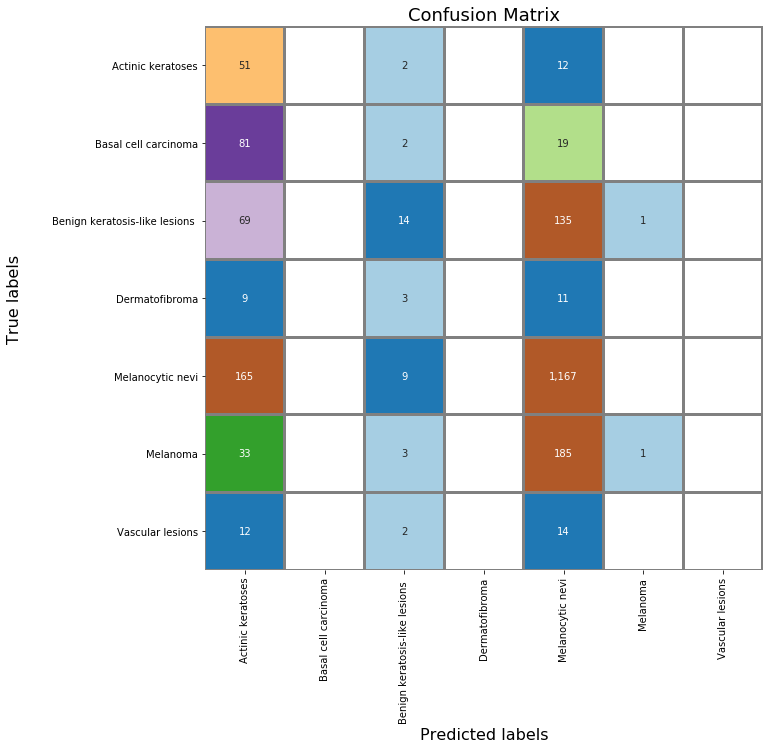

In [26]:
# Calculate Confusion Matrix
cm = confusion_matrix(te_labels.argmax(axis=1), y_pred)

# Figure adjustment and heatmap plot
f = plt.figure(figsize=(10,10))
ax= plt.subplot()
labels = df.groupby('category_id').category_name.first().values
sns.heatmap(cm, annot=True, ax = ax, vmax=100, cbar=False, cmap='Paired', mask=(cm==0), fmt=',.0f', linewidths=2, linecolor='grey', ); 

# labels
ax.set_xlabel('Predicted labels', fontsize=16);
ax.set_ylabel('True labels', labelpad=30, fontsize=16); 
ax.set_title('Confusion Matrix', fontsize=18); 
ax.xaxis.set_ticklabels(labels, rotation=90); 
ax.yaxis.set_ticklabels(labels, rotation=0);
ax.set_facecolor('white')


In [27]:
from sklearn.metrics import classification_report

In [28]:
report = classification_report(te_labels.argmax(axis=1), y_pred, target_names=df.groupby('category_id').category_name.first().values)
print(report)

                                precision    recall  f1-score   support

             Actinic keratoses       0.12      0.78      0.21        65
          Basal cell carcinoma       0.00      0.00      0.00       102
Benign keratosis-like lesions        0.40      0.06      0.11       219
                Dermatofibroma       0.00      0.00      0.00        23
              Melanocytic nevi       0.76      0.87      0.81      1341
                      Melanoma       0.50      0.00      0.01       222
              Vascular lesions       0.00      0.00      0.00        28

                     micro avg       0.62      0.62      0.62      2000
                     macro avg       0.25      0.25      0.16      2000
                  weighted avg       0.61      0.62      0.56      2000



/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [38]:
test_data, train_data, valid_data = split_images()

Found 2000 images belonging to 7 classes.
Found 6415 images belonging to 7 classes.
Found 1600 images belonging to 7 classes.


In [39]:
te_img, te_labels = next(test_data)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [40]:
cnn_bnn.evaluate(te_img, te_labels)

2000/2000 [==============================] - 4s 2ms/step


[1.8326410102844237, 0.6865]

In [44]:
y_pred = cnn_bnn.predict_classes(te_img)

In [49]:
te_labels.argmax(axis=1)[0:10]

array([2, 4, 2, 1, 4, 4, 4, 4, 4, 5])

In [50]:
confusion_matrix(te_labels.argmax(axis=1), y_pred)

array([[   1,   17,   14,    0,   33,    0,    0],
       [   1,   44,   15,    0,   42,    0,    0],
       [   3,   11,   62,    0,  142,    1,    0],
       [   1,    7,    6,    0,    9,    0,    0],
       [   1,   27,   47,    0, 1256,   10,    0],
       [   0,    1,   37,    0,  174,   10,    0],
       [   0,    8,    3,    0,   17,    0,    0]])

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

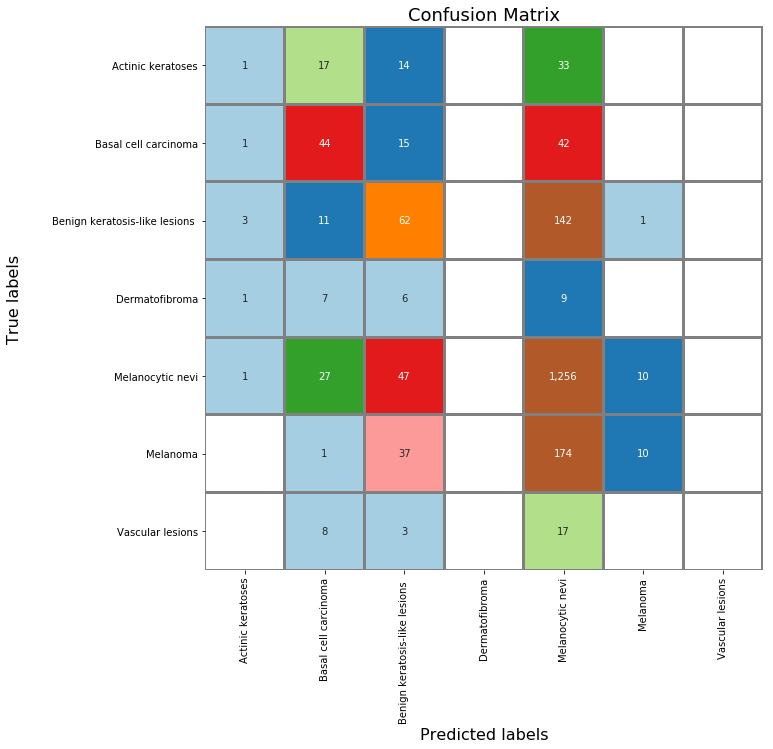

In [59]:
# Calculate Confusion Matrix
cm = confusion_matrix(te_labels.argmax(axis=1), y_pred)

# Figure adjustment and heatmap plot
f = plt.figure(figsize=(10,10))
ax= plt.subplot()
labels = df.groupby('category_id').category_name.first().values
sns.heatmap(cm, annot=True, ax = ax, vmax=100, cbar=False, cmap='Paired', mask=(cm==0), fmt=',.0f', linewidths=2, linecolor='grey', ); 

# labels
ax.set_xlabel('Predicted labels', fontsize=16);
ax.set_ylabel('True labels', labelpad=30, fontsize=16); 
ax.set_title('Confusion Matrix', fontsize=18); 
ax.xaxis.set_ticklabels(labels, rotation=90); 
ax.yaxis.set_ticklabels(labels, rotation=0);
ax.set_facecolor('white')





In [54]:
df.groupby('category_id').category_name.first().values

array(['Actinic keratoses', 'Basal cell carcinoma',
       'Benign keratosis-like lesions ', 'Dermatofibroma',
       'Melanocytic nevi', 'Melanoma', 'Vascular lesions'], dtype=object)

In [64]:
from sklearn.metrics import classification_report

In [66]:
report = classification_report(te_labels.argmax(axis=1), y_pred, target_names=df.groupby('category_id').category_name.first().values)
print(report)

                                precision    recall  f1-score   support

             Actinic keratoses       0.14      0.02      0.03        65
          Basal cell carcinoma       0.38      0.43      0.41       102
Benign keratosis-like lesions        0.34      0.28      0.31       219
                Dermatofibroma       0.00      0.00      0.00        23
              Melanocytic nevi       0.75      0.94      0.83      1341
                      Melanoma       0.48      0.05      0.08       222
              Vascular lesions       0.00      0.00      0.00        28

                     micro avg       0.69      0.69      0.69      2000
                     macro avg       0.30      0.24      0.24      2000
                  weighted avg       0.62      0.69      0.62      2000



/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
